# **导入需要的函数库**

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

# **加载数据集**
# **并将图片transform成同一格式用于训练**

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

##调用gpu进行加速
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# **可视化部分数据集**

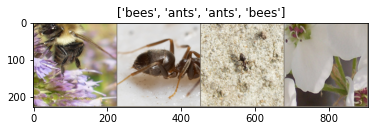

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  


##可视化部分数据
inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

##展示图片以及对应label
imshow(out, title=[class_names[x] for x in classes])

# **定义训练函数**

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# **可视化训练成果**

In [5]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# **加载预训练模型 & 重置全连接层**

In [6]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/home/zjc/anaconda3/envs/torch/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/home/zjc/anaconda3/envs/torch/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# **开始训练**

In [7]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5752 Acc: 0.7090
val Loss: 0.3981 Acc: 0.8431

Epoch 1/24
----------
train Loss: 0.4548 Acc: 0.8320
val Loss: 0.3517 Acc: 0.8627

Epoch 2/24
----------
train Loss: 0.5618 Acc: 0.7377
val Loss: 0.5555 Acc: 0.7778

Epoch 3/24
----------
train Loss: 0.5025 Acc: 0.8033
val Loss: 0.2640 Acc: 0.8889

Epoch 4/24
----------
train Loss: 0.4761 Acc: 0.8402
val Loss: 0.2912 Acc: 0.8889

Epoch 5/24
----------
train Loss: 0.4081 Acc: 0.8279
val Loss: 0.3336 Acc: 0.8693

Epoch 6/24
----------
train Loss: 0.4294 Acc: 0.8156
val Loss: 0.3194 Acc: 0.8954

Epoch 7/24
----------
train Loss: 0.3024 Acc: 0.8730
val Loss: 0.4348 Acc: 0.8301

Epoch 8/24
----------
train Loss: 0.3418 Acc: 0.8443
val Loss: 0.2845 Acc: 0.8954

Epoch 9/24
----------
train Loss: 0.3184 Acc: 0.8689
val Loss: 0.3250 Acc: 0.8758

Epoch 10/24
----------
train Loss: 0.2719 Acc: 0.8689
val Loss: 0.3142 Acc: 0.8758

Epoch 11/24
----------
train Loss: 0.2731 Acc: 0.8689
val Loss: 0.2407 Acc: 0.9085

Ep

# **可视化部分测试集**

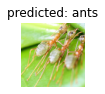

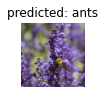

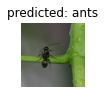

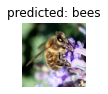

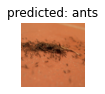

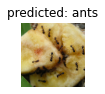

In [8]:
visualize_model(model_ft)

# **冻结除全连层以外的所有卷积层**

In [9]:
model_conv = torchvision.models.resnet50(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

# **再次进行训练**

In [17]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6188 Acc: 0.6557
val Loss: 0.5421 Acc: 0.7778

Epoch 1/24
----------
train Loss: 0.3672 Acc: 0.8074
val Loss: 0.2452 Acc: 0.9150

Epoch 2/24
----------
train Loss: 0.6317 Acc: 0.7172
val Loss: 0.2044 Acc: 0.9412

Epoch 3/24
----------
train Loss: 0.6090 Acc: 0.7377
val Loss: 0.8765 Acc: 0.6993

Epoch 4/24
----------
train Loss: 0.7705 Acc: 0.7049
val Loss: 0.2865 Acc: 0.8824

Epoch 5/24
----------
train Loss: 0.4506 Acc: 0.8074
val Loss: 0.1935 Acc: 0.9346

Epoch 6/24
----------
train Loss: 0.6355 Acc: 0.7418
val Loss: 0.2293 Acc: 0.9085

Epoch 7/24
----------
train Loss: 0.3157 Acc: 0.8607
val Loss: 0.1647 Acc: 0.9608

Epoch 8/24
----------
train Loss: 0.2704 Acc: 0.8811
val Loss: 0.1739 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.2680 Acc: 0.8607
val Loss: 0.1839 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.1874 Acc: 0.9344
val Loss: 0.1907 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.3075 Acc: 0.8607
val Loss: 0.1784 Acc: 0.9412

Ep

# **可视化预测结果**

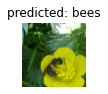

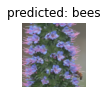

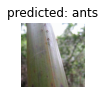

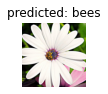

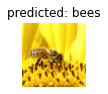

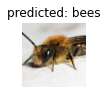

In [18]:
visualize_model(model_conv)

plt.ioff()
plt.show()